# Testing Notebook

### Import libraries

In [1]:
import sys
import os

# Manually specify the path to the 'src' directory
src_path = os.path.abspath(os.path.join(os.getcwd(), '../src'))

# Add the specified path to the system path
sys.path.append(src_path)

# Third-party libraries
import networkx as nx
from qiskit import transpile
from qiskit_ibm_runtime.fake_provider import FakeGuadalupeV2, FakeBrooklynV2
import mapomatic as mm

# Local application/library imports
import circuit_gen as circuitGen
import max_clique as maxClique
import qubit_mapping as qMap

### Parameters Configuration

In [2]:
num_modules       = 4
module_max_qubits = 4
module_max_gates  = 6
buffer_distance   = 1

### Random Circuit Generation and Mapping Computation

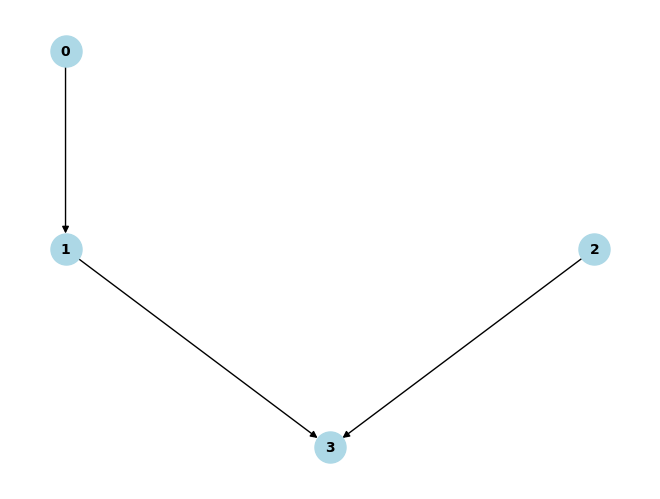

In [3]:
# Generate random circuit
circuit = circuitGen.RandomCircuit(num_modules, module_max_qubits, module_max_gates)
circuit.gen_random_circuit()

# Ploy dependency graph
circuit.draw_dependency_graph()

In [12]:
# Generate the Quantum Circuit Mapping
q_map = qMap.QubitMapping(circuit, backend=FakeGuadalupeV2(), buffer_distance=buffer_distance, reduced_distance=2, max_allowed_weight=3)
q_map.generate_qubit_mapping()
print(f"Qubit modules:  {q_map.modules_qubits}")
print(f"Qubit mapping: {q_map.qubit_mapping}")

Qubit modules:  {0: [0, 1, 2], 1: [2, 6, 7, 8], 2: [3, 4, 5], 3: [2, 5]}
Qubit mapping: [{0: [13, 12, 10], 2: [3, 5, 8]}, {1: [4, 1, 2, 0]}, {3: [1, 2]}]


Chosen layouts: {0: [13, 12, 10], 2: [3, 5, 8]}


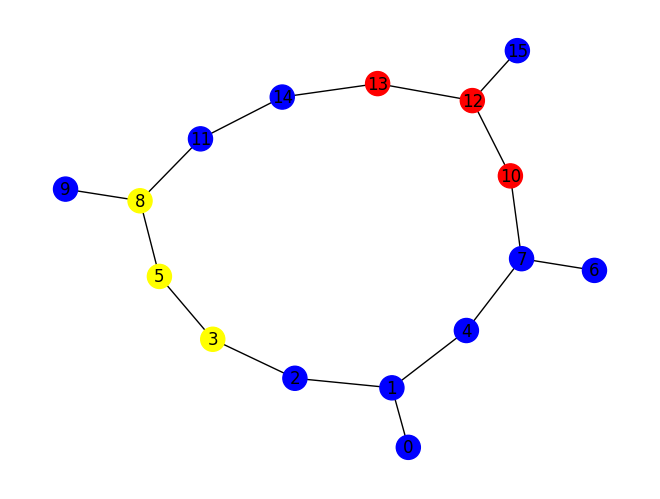

In [17]:
def generate_layouts(module, backend):
    """ Searches for, optimizes and evaluates quantum circuit layouts for a specified backend. """    
    trans_qc = transpile(module, backend, optimization_level=3)
    small_qc = mm.deflate_circuit(trans_qc)
    layouts = mm.matching_layouts(small_qc, backend)
    scores = mm.evaluate_layouts(small_qc, layouts, backend)
    return scores

backend   = q_map.backend
couplings = backend.coupling_map.get_edges()
qc_graph  = nx.from_edgelist(couplings)

# Retrieve the qubits associated with each chosen layout
timestep       = 0
chosen_layouts = q_map.qubit_mapping[timestep]
print(f"Chosen layouts: {chosen_layouts}")

# Plot the quantum circuit graph with the chosen layout for each mapped module
colors    = ['blue', 'red', 'green', 'yellow', 'orange', 'purple', 'brown', 'pink']
color_map = []

for node in qc_graph:
    in_layout = False
    for (moduleIndex, layout) in chosen_layouts.items():
        if node in layout:
            color_map.append(colors[moduleIndex + 1])
            in_layout = True            

    if not in_layout:
        color_map.append(colors[0])

nx.draw(qc_graph, node_color=color_map, with_labels=True)

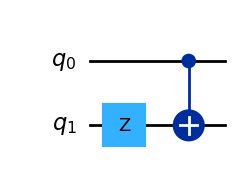

In [6]:
# Plot module of the circuit
circuit.modules[3].draw('mpl')

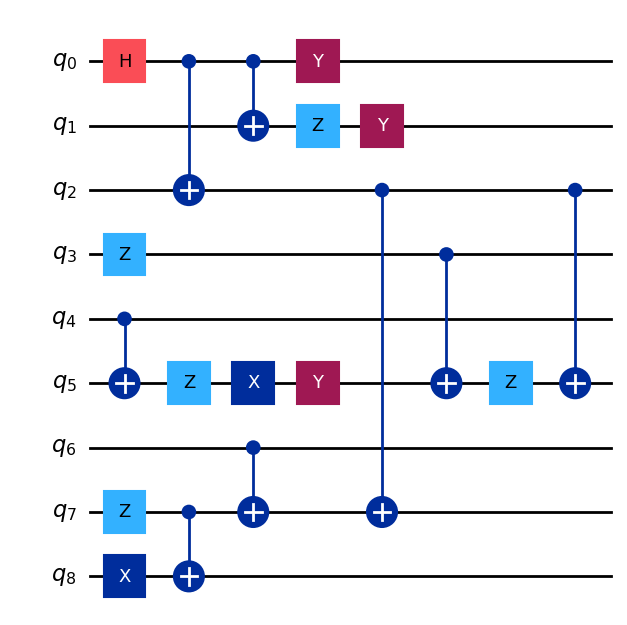

In [7]:
# Plot complete circuit
circuit.get_circuit().draw('mpl')